In this notebook, I'm using transfer learning with the VGG16 network to compare its performance to the CNN I built and trained on the PCam dataset. The advantage of using transfer learning is that we can take extremely deep CNN architectures which have been pretrained on image data, and leverage their predictive power without investing the time and computing power necessary to train the networks ourselves. By "freezing" the pretrained layers and adding a small number of trainable fully connected layers onto the output of the network, we can adapt these networks to make predictions on arbitrary image data by training only a small fraction of the total available parameters.

## 1. Setting up the Notebook

In [1]:
# Import basic data science packages
import numpy as np

# Import tensorflow packages
import tensorflow as tf
from tensorflow.test import gpu_device_name

# Import various keras tools
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### 1.1 Local Setup 
> When using Google Colab, skip this cell because the import of this library is handled in the section 1.2.

In [2]:
# pcamlib.py is my library of helper functions
import pcamlib

---

### 1.2 Google Colab Setup 
> When running locally, skip these cells and continue to section 1.3.

Set the runtime to GPU for best performance. It's a good idea when using Colab to make sure you're connected to a GPU before continuing any further.

In [ ]:
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Next, I need to mount Google Drive to access any files stored there from within Colab. This step will require following the link that appears in the cell to log into your Google account and paste the activation code in the indicated space to grant authorization to this notebook.

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

This is the path to the folder where I've cloned my GitHub repo for this project.

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone"

In [ ]:
# Navigate to the appropriate directory
%cd "{PROJECT_PATH}"

# Print the working directory to confirm the previous command worked correctly.
%pwd

I've written a library of helper functions called `pcamlib.py` which needs to be imported into Colab by running the following cell.

In [ ]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

---

### 1.3 Loading the PCam Dataset

The `.load_pcam()` function imports the Patch Camelyon dataset using `tfds.load("patch_camelyon", with_info=True)` under the hood and prints the dataset info upon completion. When using Google Colab, or if the dataset has not been previously downloaded, this cell will download the dataset from the TensorFlow database automatically, which is about 7.48 GB in size. In Colab, this cell takes between 15-20 minutes to download and prep the dataset. 

In order to save time when running locally, the dataset can be downloaded ahead of time by using the TFDS CLI command `tfds build patch_camelyon`. By default, the PCam dataset will be installed in `~/tensorflow_datasets/patch_camelyon/2.0.0`, but if you specified a different installation directory, you will need to set the `data_dir` parameter to the installation path. Unfortunately, this doesn't appear to work when trying to store the dataset in Google Drive to import directly into Colab.

In [3]:
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable

Because TensorFlow's `ImageDataGenerator()` object is difficult to configure with one of their pre-built datasets, I am utilizing code found [here](https://geertlitjens.nl/post/getting-started-with-camelyon/) to build data pipelines using `.map()`. The default batch size is 64 for the training set, and 128 for the test and validation sets.

In [4]:
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## 2.0 Training the Model

> If you are not training this model and are loading it from a file, skip ahead to section 2.2 Loading the Model - VGG16

First, we create an instance of the VGG16 network with the pretrained weights from the ImageNet dataset. It's important to set `include_top=False` so that we can strip off the Dense layers which are configured for a specified image size. `input_shape` in this case is configured to accommodate the 96x96 px, 3-channel RGB images in the PCam dataset.

In [5]:
vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

Next, we freeze the pre-trained layers so that they aren't changed during the training process.

In [6]:
# Freeze all the layers in the base model
for layer in vgg16.layers:
    layer.trainable = False

Then, we flatten the output of the final layer into a 1D array, and add a couple of Dense layers with 25% Dropout which will be trainable so that the model can learn how to identify the different classes in our PCam data. Then we add a final Dense layer with 2 outputs which will make the final class predictions for us. 

In [7]:
# Add our own layers to the end of the network
x = vgg16.output 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Add the last layer of 2 outputs for the binary image classification task
output = Dense(2, activation='softmax')(x)

vgg16 = Model(inputs=vgg16.input, 
              outputs=output)

In [8]:
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

We compile the model with the `Adam` optimizer as it is one of the most commonly used and most effective optimizers when using CNNs for image classification. We use a `categorical_crossentopy` loss function and track the accuracy of the train and validation set throughout the training process.

In [9]:
vgg16.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we create an early stopping callback function which will stop the training process early if the validation loss fails to decrease over the specified number of epochs. This allows us to set the number of training epochs to a large number without fear of wasting time going through all the epochs if they aren't improving the results.

I experimented with different values for the patience, and 8 may be slightly too long for optimal results, but I wanted to see if the networks would improve at all if left to train for a longer period of time. 

In [10]:
# Use an early stopping callback to stop training once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           mode='min', 
                           verbose=1)

This cell trains the model, and it's important to save the output into a variable called `history` so the training accuracy and loss history can be plotted later. I selected 30 epochs as an arbitrarily large number, and rely on the early stopping threshold to determine how long the model is trained. 

`steps_per_epoch` is simply the size of the training set divided by the batch size (262144 / 64) which ensures the entire training set is covered in each epoch.

Similarly, `validation_steps` is the size of the validation set divided by the batch size of the validation set (32768 / 128) to ensure the entire validation set is tested.

If changing the batch size, it's important to update these variables accordingly.

In [ ]:
%%time
history = vgg16.fit(train_pipeline,
          epochs=30,
          validation_data = valid_pipeline,
          steps_per_epoch=4096, 
          validation_steps=256,
          callbacks=[early_stop])

Here, I save the history as a pandas dataframe for easier exporting to .csv and plotting.

In [ ]:
# Convert the training history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

---

## 2.1 Saving the Model

Because the training process can take an extremely long time, it's a good idea to save the trained model, the training history, and the model predictions to external files.

I have had some issues saving and loading these models using the `model.save()` and `model.load()` functions, so I've commented these cells out for the time being until I can figure out a solution. In the meantime, I've saved the model `history` and `y_proba` to .csv files, because this information is all I need to make the plots later in this notebook and interpret them.

In [ ]:
# Save the fitted model to a file if desired
# vgg16.save('data/models/vgg16')

# For transfer learning models, it can save space to save the model in .hf5 format. 
#vgg16.save("data/models/vgg16.hf5")

In [ ]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/vgg16_history.csv')

I leave `save=False` when generating `y_proba` by default to avoid overwriting a file accidentally, change to `True` if you want to save.

On average, calculating `y_proba` takes around 40 seconds in Colab.

In [ ]:
%%time
y_proba = pcamlib.generate_y_proba(vgg16, test_pipeline, class_1=False, save=False, filepath='data/y_proba/vgg16_y_proba.csv')

---

## 2.2 Loading the Model

Commented this cell out for now until I resolve the model saving and loading issue. 

In [ ]:
# Load the model from a file
# vgg16 = tf.keras.models.load_model("data/models/vgg16.hf5")

In [11]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/vgg16_history.csv')

In [12]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/vgg16_y_proba.csv')

---

## 3.0 Evaluating the Model

I am evaluating the outputs from a trained model I've loaded from following files:
- 'data/models/history/vgg16_history.csv'
- 'data/y_proba/vgg16_y_proba.csv'

The training process has some randomness to it, because the training set is shuffled each time so the model sees training images in a different order each time, and the initialization of the weights is randomized. If you trained a model in this notebook, the results will likely be very different from what I'm describing in the markdown cells.

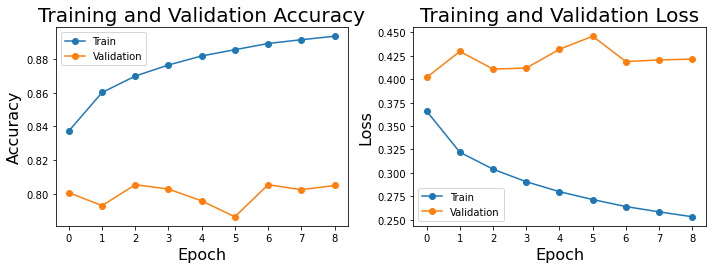

In [13]:
pcamlib.plot_history(hist_df)

This training cycle stopped after 8 epochs because the validation loss failed to decrease from the value obtained in the first epoch. There is some overfitting happening on the training set, as the training accuracy and loss diverge from the validation accuracy and loss as the number of epochs increases. This could be compensated for in the future by increasing the level of dropout between the dense layers in the network.

This cell extracts the ground truth labels from the test set and saves them as `y_true`

In [14]:
%%time
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 22.9 s, sys: 2.38 s, total: 25.3 s
Wall time: 5.29 s


This cell makes predictions based on `y_proba` with the decision threshold set to 50% by default, but this can be adjusted by specifying a different value between 0 and 1 in the `threshold` parameter.

In [15]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 9.04 ms, sys: 1.49 ms, total: 10.5 ms
Wall time: 10.1 ms


Next, we print the test accuracy by comparing the predictions on the test set to the ground truth labels.

In [16]:
%%time
pcamlib.print_test_accuracy(y_true, y_pred)

0.805328369140625
CPU times: user 4.07 ms, sys: 1.78 ms, total: 5.85 ms
Wall time: 8.05 ms


This instance of the model achieved a test accuracy of 80.5%.

Plotting the confusion matrix and printing the classification report allows us to gain additional insight into how the model makes its predictions on each class.

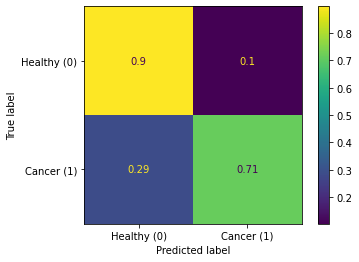

In [17]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [18]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.7576    0.8982    0.8219     16391
           1     0.8749    0.7124    0.7853     16377

    accuracy                         0.8053     32768
   macro avg     0.8162    0.8053    0.8036     32768
weighted avg     0.8162    0.8053    0.8036     32768



The metric we are most interested in is the recall of the positive class, as this represents the percentage of cancer that the model is able to identify. This model acheived a recall of 71.2%. While better than the pathologist benchmark, this is not as good as some of the other models. This model appears to favour predicting healthy tissue, correctly identifying around 90% of healthy tissue, but also misclassifying nearly 30% of cancer tissue as healthy.

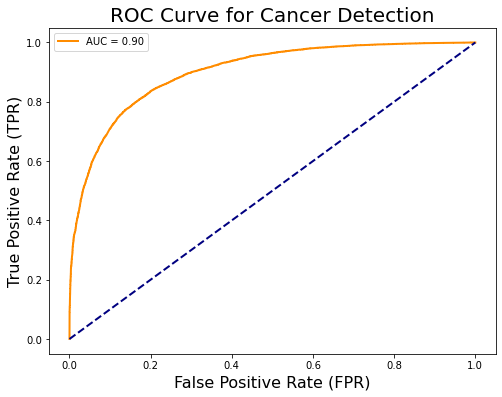

Area under curve (AUC):0.9004104998712037
(9382,)
(9382,)


In [19]:
pcamlib.plot_roc_curve(y_true, y_proba)

By plotting the Receiver Operating Characteristic Curve, and calculating the Area Under the Curve, we can get a high level understanding of how well the model performed overall, and most importantly, compare this metric to other models as well as the pathologists' score. An AUC of 0.90 is very good, but because this model struggled with correctly predicting the positive class, it's not necessarily well suited to prescreening histopathology samples.

Misclassified Image Indices: 
4
5
12
14
15
17
19
32
33


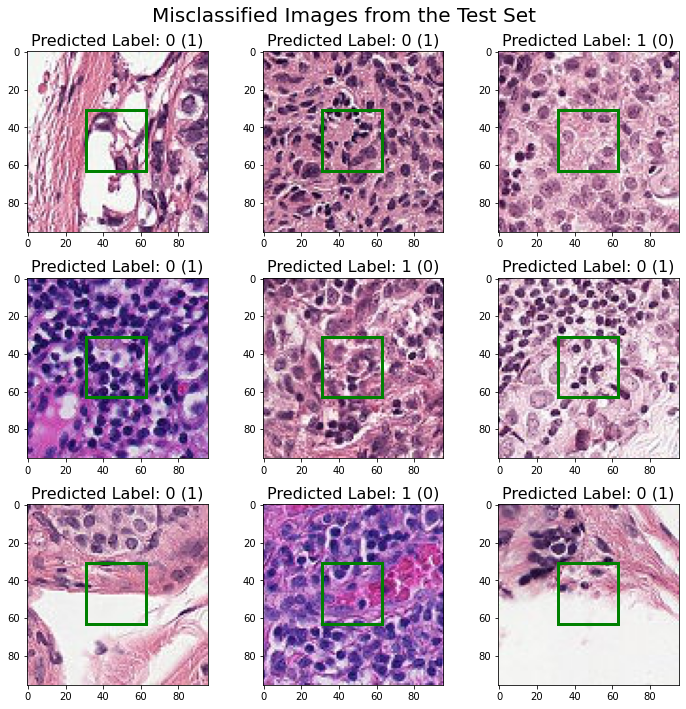

In [20]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

One of the most difficult tasks in this project is interpreting these images which are misclassified by the model, because it takes years of specialized training as a pathologist to differentiate cancer tissue from healthy lymph node tissue. From my understanding, one way to identify cancer in these samples is by looking for the enlarged cells, with a larger, less dense nucleus that shows up as a lighter shade of pink when stained compared to the darker purple nuclei of the healthy cells. This is caused by the uncontrolled growth of the cancerous cells.

However, I have two hypotheses for why these images may be misclassified:
- First, and this applies to all of the images in general, because the class labelling is dependent on the presence of cancer in the central region of the image outlined by the green box, the model may be making decisions based on tissue outside of that area which may be cancerous, but doesn't contribute to the class label.
- Secondly, because these are thin cross sections of lymph nodes, there are often large areas of white space which represent the edges, or empty spaces inside the lymph nodes. This gives the model less information to work with.